In [2]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np

from typing import List

In [3]:
MAX_NODULE_WIDTH = 100
MAX_NODULE_HEIGHT = 100

In [4]:
def zoomout_nodule(bbox, width, height):
    # TODO: what if is outside the picture?
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].stop + x_acres, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].stop + y_acres, None)

    return (x_slice, y_slice, bbox[2])

Loading dicom files ... This may take a moment.


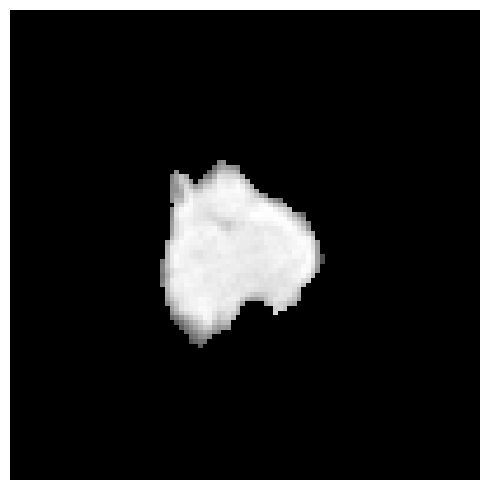

In [12]:
def get_cropped_annot(scan: pl.Scan, mask: bool=False):
    vol = scan.to_volume()

    images = []
    masks = []

    nods = scan.cluster_annotations()
    for anns in nods:
        cmask, cbbox, masks = consensus(anns, clevel=0.5,
                                pad=[(10,10), (10,10), (0,0)])

        full_mask = np.full_like(vol, False, dtype=bool)
        full_mask[cbbox] = cmask

        cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT)
        cropped = vol[cbbox]
        cropped_mask = ~full_mask[cbbox]
        if mask:
            cropped[cropped_mask] = -1000 # TODO: maybe pick different value

        # Scale values
        # TODO: maybe pick different values
        cropped += 1000
        cropped = cropped / 2000

        images.append(cropped)
        masks.append(cropped_mask)

    return images, masks


scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
cropped, _ = get_cropped_annot(scan, True)

# Set up the plot.
plt.figure(figsize=(5,5))
k = int(0.5*cropped[0].shape[2])
plt.imshow(cropped[0][:,:,k], cmap=plt.cm.gray)

plt.axis('off')
plt.tight_layout()
plt.show()